# Template Code for Star Cluster Analysis with AI: ERIRA 2024
## Part 1: code environment and data file set-up

In [1]:
# import some useful libraries
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## dataset setup

In [2]:
working_folder = '.'
data_folder = os.path.join(working_folder, 'data/raw_data')

if not os.path.exists(data_folder):
  os.makedirs(data_folder)

Next, put the images zip file and labels .csv file into the `data/raw_data` folder.

In [3]:
# unzip image data
source_images_zip_filename = os.path.join(data_folder, 'images.zip')
source_images_folder = os.path.join(data_folder, 'images')

import zipfile
with zipfile.ZipFile(source_images_zip_filename, 'r') as zip_ref:
    zip_ref.extractall(source_images_folder)

# load and view data labels mounted from drive
labels_path = os.path.join(data_folder,
                           'mwsc_sdss.csv')
data_labels = pd.read_csv(labels_path)
display(data_labels)

,id,name,ra(degs),dec(degs),radius(degs),num_stars,age(log),cluster_type,age classification
0,7034df0785134fb1,vdBergh 113,272.175,-21.405,0.202,67,8.300,OPEN,YOUNG
1,5bbee62977f7d95a,FSR 0031,271.622,-21.380,0.140,39,8.550,OPEN,INTERMEDIATE
2,348f31ca10e44e71,2MS-GC02,272.380,-20.790,0.105,36,10.000,GLOBULAR,OLD
3,9beca73bad344132,Sgr OB7,273.720,-20.320,0.480,592,6.450,ASSOCIATION,YOUNG
4,dbf852e2cbccfb9a,FSR 0035,271.072,-20.178,0.085,48,6.600,OPEN,YOUNG
...,...,...,...,...,...,...,...,...,...
511,3da0061a52ee3e24,NGC 7708,354.075,72.851,0.195,110,8.760,OPEN,INTERMEDIATE
512,1695d7c6751fcf83,FSR 0466,351.853,73.202,0.140,40,8.895,OPEN,INTERMEDIATE
513,f9686f2aaf879fac,FSR 0472,354.007,73.860,0.320,78,7.450,ASSOCIATION,YOUNG
514,7a958bf81f014b85,FSR 0410,313.808,76.395,0.120,12,9.200,OPEN,INTERMEDIATE


## Part 2: Create PyTorch Dataset for training your network

In [4]:
# create PyTorch Dataset (no need to modify this by default)
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

CLUSTER_AGE_CLASSES = ['YOUNG', 'INTERMEDIATE', 'OLD']

class StarClusterDataset(Dataset):
  def __init__(self,
               images_folder,
               labels_path,
               img_size,
               label_name,
               label_type
               ):
    self.img_size = img_size

    self.images_folder = images_folder
    image_ids = [f.split('.')[0] for f in os.listdir(os.path.join(images_folder))]
    self.image_labels = pd.read_csv(labels_path)
    self.image_labels = self.image_labels[self.image_labels['id'].isin(image_ids)]

    self.label_name = label_name
    self.label_type = label_type

    assert self.label_type in ['classification', 'regression', 'string']

  def __len__(self):
    return len(self.image_labels)

  def transform(self, image):
    # transformations to apply to image (tensor) after loading
    # convert from integer to float for normalization
    image = image.float()

    # normalize it
    image = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image)
    # finally, resize it
    image = transforms.Resize(self.img_size)(image)

    return image

  def __getitem__(self, idx):
    # get cluster ID of image
    cluster_ID = self.image_labels['id'].iloc[idx]
    # print(galaxy_ID)

    # get filepath of image and load it
    image_filename = str(cluster_ID) + '.jpeg'
    image_path = os.path.join(self.images_folder, image_filename)

    # load image and convert to torch Tensor (array-like)
    image = read_image(image_path)

    # convert image to torch Tensor, normalize and resize
    image = self.transform(image)

    # get labels for the images
    label = self.image_labels[self.label_name].iloc[idx]

    # convert labels for usage in PyTorch
    if self.label_type == 'classification':
      # convert age classification strings to class integers
      label = CLUSTER_AGE_CLASSES.index(label)
    elif self.label_type == 'regression':
      # convert age regression strings to float32
      label = torch.tensor([label], dtype=torch.float32)
    elif self.label_type == 'string':
      pass

    return image, label

### Part 2b: split data set into training set and testing set

In [5]:
# build dataset and split it into train and test sets
image_size = 224

# decide if you want to do classification or regression
label_name = "age classification"
label_type = 'classification'
train_dataset = StarClusterDataset(
    source_images_folder + '/trainset',
    labels_path,
    image_size,
    label_name,
    label_type=label_type
)

test_dataset = StarClusterDataset(
    source_images_folder  + '/testset',
    labels_path,
    image_size,
    label_name,
    label_type=label_type
)

print(len(train_dataset), len(test_dataset))

450 66


### Part 2c: look at some of your dataset

In [6]:
# test out creating a DataLoader and view some data from the training dataset
example_batch_size = 5 # number of images and labels to load at once
example_loader = DataLoader(train_dataset,
                                     batch_size=example_batch_size,
                                     shuffle=True # images are loaded in random order
                          )


# helper function for plotting a batch of images
from torchvision.utils import make_grid

def plot_imgbatch(imgs):
    imgs = imgs.cpu()
    imgs = imgs.type(torch.IntTensor)
    plt.figure(figsize=(15, 3*(imgs.shape[0])))
    grid_img = make_grid(imgs, nrow=5)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).





image batch 0:


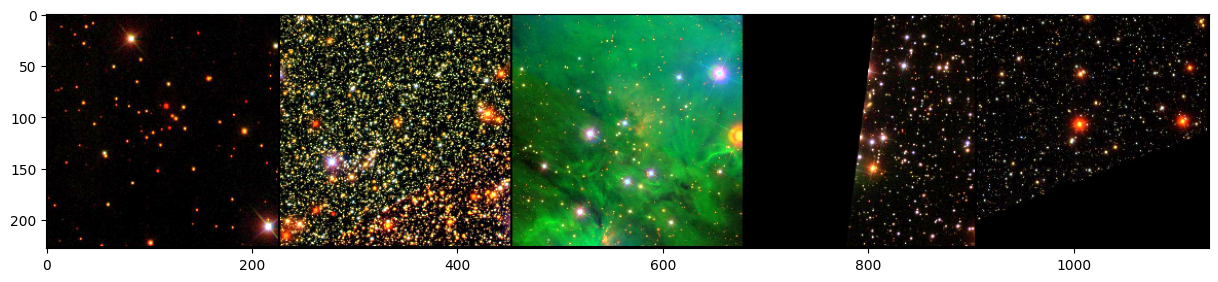

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels of images from batch 0:
tensor([0, 1, 0, 1, 1])



image batch 1:


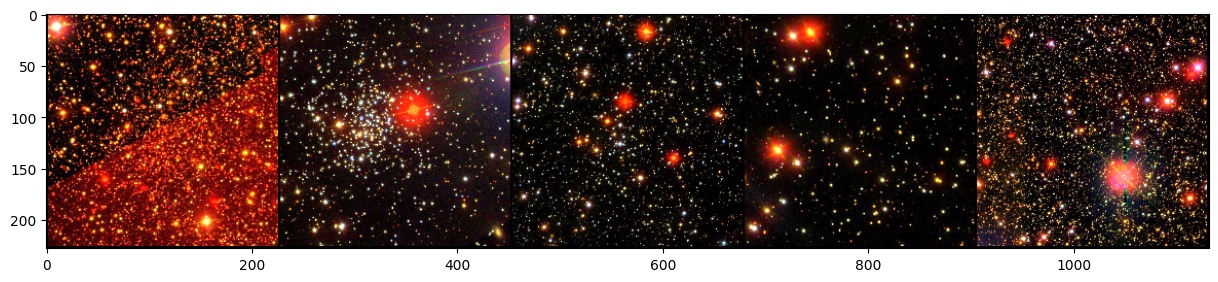

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels of images from batch 1:
tensor([1, 1, 1, 1, 1])



image batch 2:


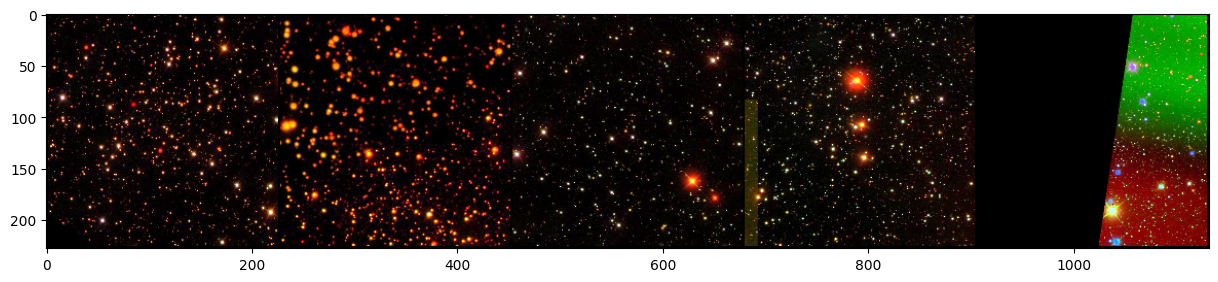

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels of images from batch 2:
tensor([1, 0, 1, 1, 1])



image batch 3:


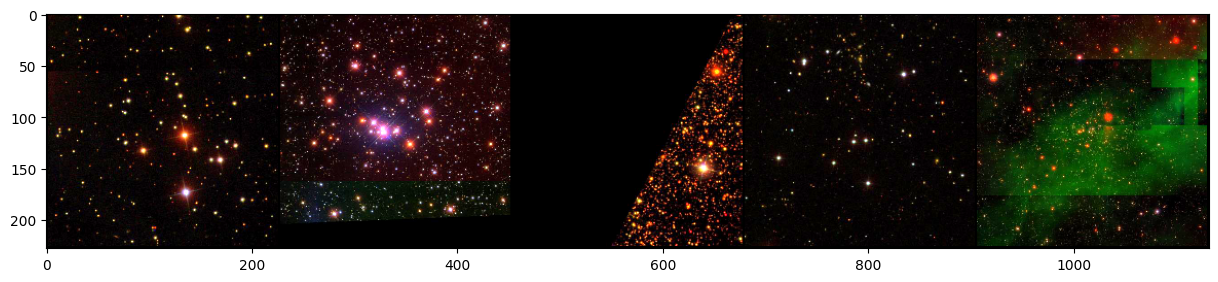

labels of images from batch 3:
tensor([1, 1, 1, 1, 1])


In [7]:
# iterate through a few batches of example images with the DataLoader
for batch_index, (images, labels) in enumerate(example_loader):
  print('\n\n\nimage batch {}:'.format(batch_index))
  plot_imgbatch(images)
  print('labels of images from batch {}:'.format(batch_index))
  print(labels)
  if batch_index > 2:
    # plot just a few examples
    break

## Part 3: Get ready for neural network training!

### Part 3a: GPU setup
Next, we need to set up for doing all of our computations on Colab's free supplied GPU. Before we do this, note that do to your free google colab membership, the *amount* of computation that you can use is limited, so *start small* with how much computation you use.

- **start with small training set sizes (1000 should be plenty at first)**
- **start with small neural networks (the resnet18 I give as an example is good)**

Also, in the code I will supply I make it so that your networks are saved throughout training, so that you can load them at any point later without re-training and using up more compute.

Anyways, you can attach data and neural networks to the GPU as follows. PyTorch interfaces with the GPU using software called "CUDA", which you don't need to know except by name.

Make sure the following outputs "running on cuda", not "running on cpu"! If not, you'll need to connect to a GPU with the "Connect" button near the top right of the Colab menu.


In [8]:
# specify the computation device by creating a variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('running on {}'.format(device))
# from here, you can load stuff onto the device basically
#   with "stuff = stuff.to(device)" (there will be examples in the code)

running on cpu


### Part 3b: DataLoader set-up

In [9]:
# build dataloaders
train_batchsize = 16 # depends on your computation hardware:
# remember that as image size increases,
# batch size should decrease
eval_batchsize = 8 # batch size for evaluating on test set: can be small
train_loader = DataLoader(train_dataset,
                                     batch_size=train_batchsize,
                                     shuffle=True
                                     # images are loaded in random order
                                                )
test_loader = DataLoader(test_dataset,
                        batch_size=eval_batchsize)

### Part 3c: set up your neural network
Here I supply you a well-known neural network, ResNet18, as neural network design is beyond the scope of this project (but feel free to try your own)! You could also attempt other classification networks (see [here](https://pytorch.org/vision/stable/models.html#classification)) if you'd like, but this could drastically increase your computation.

The one modification to this network is to change the number of outputs to be the number of answer probabilities that the network provides as answers to the Galaxy Zoo questions.

Recall that at first, we'll just worry about the first question, which has three answers. Later you could try the full decision tree of 11 questions, which has 37 answers (which is why each row in the label file has 37 probabilities)

In [10]:
# modified resnet to allow for dropout after each conv layer
from torchvision.models.resnet import BasicBlock, ResNet

class DropoutResNet(ResNet):
    def __init__(self, block, layers, prediction_size, dropout_prob=0.5):
        super(DropoutResNet, self).__init__(block, layers, num_classes=prediction_size)
        self.dropout_prob = dropout_prob

        # Adding dropout layers
        self.dropout1 = torch.nn.Dropout(p=self.dropout_prob)
        self.dropout2 = torch.nn.Dropout(p=self.dropout_prob)
        self.dropout3 = torch.nn.Dropout(p=self.dropout_prob)
        self.dropout4 = torch.nn.Dropout(p=self.dropout_prob)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)  # Dropout after first conv layer
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.dropout2(x)  # Dropout after first block
        x = self.layer2(x)
        x = self.dropout3(x)  # Dropout after second block
        x = self.layer3(x)
        x = self.dropout4(x)  # Dropout after third block
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def dropout_resnet18(dropout_prob=0.5, **kwargs):
    return DropoutResNet(BasicBlock, [2, 2, 2, 2], dropout_prob=dropout_prob, **kwargs)

In [11]:
from torchvision.models.resnet import resnet18
# instantiate classifier from ResNet-18 neural network model
# modify final layer of classifier to output correct number of answers
prediction_size = 1 if label_type == 'regression' else len(CLUSTER_AGE_CLASSES)

use_dropout_network = False
print('using dropout network for uncertainty!', use_dropout_network)
if use_dropout_network:
    net = dropout_resnet18(prediction_size=prediction_size)
else:
    net = resnet18()
    net.fc = torch.nn.Linear(in_features=512, out_features=prediction_size, bias=True)

# load neural net to GPU device
net = net.to(device)

using dropout network for uncertainty! False


### Part 3d: set up the backbone of training: the Loss Function and Optimizer

The loss/error function, otherwise known as the criterion, measures the difference between the network's predictions on an image, and the expected predictions that come from the image labels. For our task, the network predicts probabilites of each question answer (3 answers for 1 question for the basic task, 37 answers for 11 questions for the full task).

To measure this, we will use the *mean-squared error*. For a single image/prediction with $N$ answers, the mean-squared error between the predicted probability answers and the expected (labeled) values is

\begin{align}
\frac{1}{N}\sum_{i=1}^{N}(p_i^\mathrm{prediction} - p_i^\mathrm{label})^2,
\end{align}

where $p_i^\mathrm{prediction}$ is the predicted probability for the $i^{th}$ answer, and $p_i^\mathrm{label}$ is the "correct" expected answer according to the lab for the image. We can estimate the error over the entire training set of images simply by averaging the errors for each image.

This is SUPER easy to set up in PyTorch:


In [14]:
# weight each class inversely proportional to its frequency
# in the training set
# this is useful for imbalanced datasets
use_classweighted_loss = False
if use_classweighted_loss:
    class_weights = []
    for c in CLUSTER_AGE_CLASSES:
        w = 1. / len(train_dataset.image_labels[train_dataset.image_labels[label_name] == c]) 
        class_weights.append(w)
    class_weights = torch.tensor(class_weights).to(device).squeeze()
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights) if label_type == 'classification' else torch.nn.MSELoss()
else:
    criterion = torch.nn.CrossEntropyLoss() if label_type == 'classification' else torch.nn.MSELoss()
# criterion = torch.nn.CrossEntropyLoss() if label_type == 'classification' else torch.nn.MSELoss()

That was how we can measure the prediction error of the network, which we want to minimize. Now, how do we actually minimize the error (the *learning* itself)?

We want to tune all of the parameters of the neural network (image millions of tiny knobs like that of a radio) such that the error is minimized. The parameter values needed to minimize the error cannot be solved for mathematically, but we can still use an *optimizer* algorithm to iteratively evolve parameter values to get lower and lower errors, because we can exactly estimate which "direction" to change the parameters in to make the error lower (if you've taken multivariable calculus, this is just the negative gradient).

There are many different optimization algorithms for this, but here I will use the most basic, which should be fine.

I invite you to try other optimizers for training; see [here](https://pytorch.org/docs/stable/optim.html#algorithms) for more info. This could lead to better prediction performance, but could also be more complicated.

For most optimization algorithms, you'll need to specify the *learning rate*. This is essentially the approximate magnitude of much parameters will be adjusted during training. If the learning rate is too high, the training may be unstable, but if it's too low, the training may go too slow and we will never reach good performance. You should mess around with training with different values of this parameter, as it can drastically change how well your model is trained! For now I'll start with a reasonable value.

You also need to specify the total number of *learning iterations*, or *epochs*. We evaluate the network on the entire training set for a single epoch. A reasonable value is 50, but mess around with this! If you're learning rate is too low, you may need more epochs to evolve to good performance.

In [15]:
learning_rate = 0.1
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

epochs = 100

### Part 3e: Measuring Performance of the Network

The prediction error of the neural network on the training set is central to the training of the network (this is what we're minimizing), but at the end of the day **we want to use our network on any, unseen, data**. This is the purpose of the test set.

As such, we can best estimate the performance of the network using the *prediction error on the test set*. In the subsequent training code I will show how to estimate this.

It is also useful to make it so that whenever an iteration of training results in better performance on the test dataset (unseen images, which is the goal), i.e. lower prediction error/loss, that network is saved as a file that you can load later. This code accomplishes that:

In [16]:
# save model if test error is lower
# (name by date/time)
from datetime import datetime

saved_model_folder = os.path.join(working_folder, 'saved_models')
if not os.path.exists(saved_model_folder):
  os.makedirs(saved_model_folder)

now = datetime.now()
date_time = now.strftime("%m_%d_%Y__%H_%M_%S")
saved_model_filename = 'trainedmodel_{}_{}'.format(date_time, label_name)

# add a custom name to your saved model HERE!
# to specify how you're training this one
custom_name = ''
saved_model_filename += custom_name + '.pt'

saved_model_path = os.path.join(saved_model_folder, saved_model_filename)

saved_model_path_notesterror = saved_model_path

# LOAD IN A PRE-TRAINED MODEL IF YOU WANT for further training
load_pretrained = False
if load_pretrained:
  # load in pretrained model as a state dict
  load_model_filename = ''
  load_model_path = os.path.join(saved_model_folder, load_model_filename)
  state_dict = torch.load(load_model_path)

  # load state dict into network
  net.load_state_dict(state_dict)


## Part 4: Let's Train this Bad Boy!
NOTE: can skip these cells if you want to go straight to testing.

In [ ]:
use_training_transform = True

# random transformation for training images
training_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(image_size, image_size), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5)
])

In [ ]:
best_test_loss = float('inf')
# make the best test error infinitely high by default
# (so that the first model is saved)
if label_type == 'classification':
	best_test_acc = 0

for epoch in range(epochs):
	# set network to training mode, so that its parameters can be changed
	net.train()

	# print training info
	print("### Epoch {}:".format(epoch))

	# initialize statistics needed to compute overall error/loss
	train_error = 0
	test_error = 0

	# for computing training accuracy
	correct = 0
	total = 0

	# iterate over the training set once
	for batch_index, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader.dataset)//train_batchsize):
		# load the data onto the computation device.
		# inputs are a tensor of shape:
		#   (batch size, number of channels, image height, image width).
		# targets are a tensor of one-hot-encoded class labels for the inputs,
		#   of shape (batch size, number of classes)
		# in other words,
		inputs = inputs.to(device)
		targets = targets.to(device)

	  	# apply transforms
		if use_training_transform:
			inputs = training_transform(inputs)

		# reset changes (gradients) to parameters
		optimizer.zero_grad()

		# get the network's predictions on the training set batch
		predictions = net(inputs)

		# evaluate the error, and estimate
		#   how much to change the network parameters
		loss = criterion(predictions, targets)
		loss.backward()
		train_error += loss.item()

		# change parameters
		optimizer.step()

		# eval accuracy
		if label_type == 'classification':
			_, predicted = torch.max(predictions, 1)
			total += targets.size(0)
			correct += (predicted == targets).sum().item()

	# overall results on training set
	# error in predicted probabilities
	avg_loss_train = train_error / (batch_index + 1)
	print("Average Training Loss : %.4f" %(avg_loss_train))

	# accuracy
	if label_type == 'classification':
		accuracy = 100 * correct / total
		print('Accuracy of the network on the training images: %d %%' % (accuracy))

	# get results for this epoch on test set

	# evaluating, not training
	net.eval()

	# for computing test accuracy
	correct = 0
	total = 0
	for batch_index, (inputs, targets) in tqdm(enumerate(test_loader), total=len(test_loader.dataset)//eval_batchsize):
		inputs = inputs.to(device)
		targets = targets.to(device)
		# get the network's predictions on the training set batch
		predictions = net(inputs)

		# evaluate the error
		loss = criterion(predictions, targets)
		test_error += loss.item()

		# eval accuracy
		if label_type == 'classification':
			_, predicted = torch.max(predictions, 1)
			total += targets.size(0)
			correct += (predicted == targets).sum().item()

	# error in predicted probabilities
	avg_loss_test = test_error / (batch_index + 1)
	print("Average Test Loss: %.4f" %(avg_loss_test))

	# accuracy
	if label_type == 'classification':
		test_acc = 100 * correct / total
		print('Accuracy of the network on the test images: %d %%' % (test_acc))



  # save trained network as file (make sure you can find it!)
  # if the test error was improved/made lower
	save_new_model = False
	if label_type == 'classification':
		if test_acc > best_test_acc:
			save_new_model = True
			best_test_acc = test_acc

	else:
		if avg_loss_test < best_test_loss:
			save_new_model = True
			best_test_loss = avg_loss_test

	if save_new_model:
		# delete previous saved model
		if os.path.exists(saved_model_path):
			os.remove(saved_model_path)

		# save new better odel
		best_performance = test_acc if label_type == 'classification' else avg_loss_test
		new_model_path = saved_model_path_notesterror.replace('.pt', '_testperf_{}.pt'.format(round(float(best_performance), 3)))
		if use_dropout_network:
			new_model_path = new_model_path.replace('.pt', '_dropout.pt')

		print('better test performance, saving model as {}'.format(os.path.split(new_model_path)[1]))
		torch.save(net.state_dict(), new_model_path)

		saved_model_path = new_model_path

## Part 5: Loading and Testing the trained network

In [17]:
# first, load the trained model
if not os.path.exists(saved_model_folder):
    os.makedirs(saved_model_folder)

load_model_filename = 'trainedmodel_06_12_2024__19_42_29_age classification_testperf_69.697.pt'
load_model_path = os.path.join(saved_model_folder, load_model_filename)
state_dict = torch.load(load_model_path)

# load state dict into network
net.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

In [18]:
# evaluate the model on images from some folder of choice
testset2_folder_name = 'data/raw_data/images/testset'
testset2_labels_path = 'data/raw_data/mwsc_sdss.csv'

test_dataset2 = StarClusterDataset(
    testset2_folder_name,
    testset2_labels_path,
    image_size,
    label_name,
    label_type=label_type
)

print(len(test_dataset2))
test2_loader = DataLoader(test_dataset2, batch_size=eval_batchsize)

66


In [19]:
prediction_size = 1 if label_type == 'regression' else len(CLUSTER_AGE_CLASSES)

use_dropout_network = False
print('using dropout network for uncertainty!', use_dropout_network)
if use_dropout_network:
    net2 = dropout_resnet18(prediction_size=prediction_size)
else:
    net2 = resnet18()
    net2.fc = torch.nn.Linear(in_features=512, out_features=prediction_size, bias=True)

# load neural net to GPU device
net2 = net2.to(device)

net2.load_state_dict(torch.load(''), strict=True)

using dropout network for uncertainty! False


FileNotFoundError: [Errno 2] No such file or directory: ''

## Special Testing Options

In [20]:
VISUALIZATIONS_FOLDER = os.path.join(working_folder, 'visualizations')
if not os.path.exists(VISUALIZATIONS_FOLDER):
    os.makedirs(VISUALIZATIONS_FOLDER)

# special testing options
create_saliency_maps = False
if create_saliency_maps:
    if label_type != 'classification':
        raise ValueError('saliency maps only work for classification tasks')

    # run pip install grad-cam to use this function
    from pytorch_grad_cam import GradCAM

save_image_features = False
if save_image_features:
    test_set_features = []
    test_set_labels = []

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    net.layer4.register_forward_hook(get_activation('layer4'))

plot_calibration = False
if plot_calibration:
    all_class_probs = {i: [] for i,_ in enumerate(CLUSTER_AGE_CLASSES)}
    all_class_binary_labels = {i: [] for i,_ in enumerate(CLUSTER_AGE_CLASSES)}

In [21]:
import relplot as rp
## evaluate the network on the additional test set

# if network was trained with do dropout, use dropout for testing
# for added network variability
if use_dropout_network:
    net.train()
    print('using dropout network for testing')
else:
    net.eval()

if create_saliency_maps:
    print('creating saliency maps for test set with gradCAM')

    # Construct the CAM object once, and then re-use it on many images:
    if label_type == "classification":
        try:
            target_layers = [net.module.layer4[-1]]
        except AttributeError:
            target_layers = [net.layer4[-1]]
    else:
        raise NotImplementedError
    cam = GradCAM(model=net, target_layers=target_layers) #, use_cuda=use_cuda)


test_error = 0
# for computing test accuracy
correct = 0
total = 0

# for computing per-class test accuracy
class_correct = list(0. for i in range(len(CLUSTER_AGE_CLASSES)))
class_total = list(0. for i in range(len(CLUSTER_AGE_CLASSES)))

for batch_index, (inputs, targets) in tqdm(enumerate(test2_loader), total=len(test2_loader.dataset)//eval_batchsize):
    inputs = inputs.to(device)
    targets = targets.to(device)
    # get the network's predictions on the training set batch
    predictions = net(inputs)

    # get cluster IDs of images
    # get dataset indices from batch index
    # idxs = np.arange(len(test2_loader.dataset))[batch_index * eval_batchsize:(batch_index + 1) * eval_batchsize]
    # cluster_IDs = [test2_loader.dataset.image_labels['id'].iloc[idx] for idx in idxs]
    # for j in range(len(cluster_IDs)):
    #     print(cluster_IDs[j], predictions[j].item())

    if plot_calibration:
        # get predicted probabilities and binary labels for each class
        probs = torch.nn.functional.softmax(predictions, dim=1).cpu().detach().numpy()
        for c in range(probs.shape[1]):
            class_labels = targets.cpu().detach().numpy() == c
            all_class_binary_labels[c].append(class_labels)
            probs_thisclass = probs[:, c]
            all_class_probs[c].append(probs_thisclass)

    if save_image_features:
        # flatten the features except for batch dimension
        test_set_features.append(activation['layer4'].view(activation['layer4'].shape[0], -1).cpu().numpy())
        test_set_labels.append(targets.cpu().numpy())

    # evaluate the error
    loss = criterion(predictions, targets)
    test_error += loss.item()

    # eval accuracy
    if label_type == 'classification':
        _, predicted = torch.max(predictions, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # for computing per-class test accuracy
        for c in range(len(CLUSTER_AGE_CLASSES)):
            class_total[c] += (targets == c).sum().item()
            class_correct[c] += (predicted == targets)[targets == c].sum().item()


    if create_saliency_maps:
        for i in tqdm(range(inputs.shape[0])):
            one_input = inputs[i].unsqueeze(0)

            grayscale_cam = cam(input_tensor=one_input)
            fig, axs = plt.subplots(2, 1, figsize=(3,6))
            # remove axes
            for ax in axs:
                ax.axis('off')
            
            img_plot = one_input.squeeze().cpu().numpy().transpose(1, 2, 0)
            # normalize image for plotting range
            img_plot = (img_plot - img_plot.min()) / (img_plot.max() - img_plot.min())
            axs[0].imshow(img_plot)
            axs[1].imshow(img_plot)
            axs[1].imshow(grayscale_cam[0], alpha=0.4, cmap='jet')
            iscorrect = int(targets[i] == predicted[i])
            plt.savefig(os.path.join(VISUALIZATIONS_FOLDER, "gradcam_{}_{}_{}.png".format(batch_index, i, iscorrect)))

# error in predicted probabilities
avg_loss_test = test_error / (batch_index + 1)
print("Average Test Loss: %.4f" %(avg_loss_test))

# accuracy
print('correct', correct, 'total', total)
if label_type == 'classification':
    test_acc = 100 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (test_acc))
    
    # for computing per-class test accuracy
    for i in range(len(CLUSTER_AGE_CLASSES)):
        print('Accuracy of the network on the test images for class {}: {} %'.format(CLUSTER_AGE_CLASSES[i], 100 * class_correct[i] / class_total[i]))
    
if save_image_features:
    test_set_features = np.concatenate(test_set_features, axis=0)
    
    # save test set features as a numpy array file which can be loaded later
    test_set_features_path = os.path.join(VISUALIZATIONS_FOLDER, 'test_set_features.npy')
    np.save(test_set_features_path, test_set_features)
    print('saved test set features to {}'.format(test_set_features_path))

if plot_calibration:
    # plot calibration curve
    raise NotImplementedError('the library is buggy and not working properly, so this is commented out for now')
    for c in range(len(CLUSTER_AGE_CLASSES)):
        f = np.concatenate(all_class_probs[c])
        y = np.concatenate(all_class_binary_labels[c])
        print(f.shape, y.shape)
        calib_error = rp.smECE(f=f, y=y)
        rp.rel_diagram(f=f, y=y)

        plt.savefig(os.path.join(VISUALIZATIONS_FOLDER, 'calibration_curve_class{}.png'.format(c)))
        plt.show()

9it [00:01,  5.19it/s]                       

Average Test Loss: 0.8260
correct 46 total 66
Accuracy of the network on the test images: 69 %
Accuracy of the network on the test images for class YOUNG: 0.0 %
Accuracy of the network on the test images for class INTERMEDIATE: 100.0 %
Accuracy of the network on the test images for class OLD: 0.0 %


In [ ]:
feats = np.load(test_set_features_path)

In [ ]:
feats[0].shape

# OOD image detection

In [ ]:
# get average train set features
train_set_features_path = os.path.join(VISUALIZATIONS_FOLDER, 'train_set_features_ageclassif.npy')
feats_train = np.load(train_set_features_path)
print(feats_train.shape)
avg_feats_train = np.mean(feats_train, axis=0)

ood_testset_folder_name = 'data/raw_data/images/ood_testset/noncluster'
id_testset_folder_name = 'data/raw_data/images/ood_testset/cluster'
ood_testset_labels_path = 'data/raw_data/mwsc_sdss.csv'

id_test_dataset = StarClusterDataset(
    id_testset_folder_name,
    ood_testset_labels_path,
    image_size,
    label_name,
    label_type=label_type
)

ood_test_dataset = StarClusterDataset(
    ood_testset_folder_name,
    ood_testset_labels_path,
    image_size,
    label_name,
    label_type=label_type
)

print(len(id_test_dataset), len(ood_test_dataset))

In [ ]:
anomaly_scores = []
anomaly_labels = []
ood_test_loader = DataLoader(ood_test_dataset, batch_size=4)
id_test_loader = DataLoader(id_test_dataset, batch_size=4)

for loader_idx, loader in enumerate([id_test_loader, ood_test_loader]):
    for batch_index, (inputs, _) in tqdm(enumerate(loader)):
        inputs = inputs.to(device)
        # get the network's predictions on the training set batch
        predictions = net(inputs)

        img_features = activation['layer4'].view(activation['layer4'].shape[0], -1).cpu().numpy()

        scores = np.linalg.norm(img_features - avg_feats_train, axis=1)
        anomaly_scores.append(scores)

        anomaly_labels.append(
            np.zeros(img_features.shape[0]) if loader_idx == 0 else np.ones(img_features.shape[0])
        )


In [ ]:
# compute AUC
anomaly_scores = np.concatenate(anomaly_scores)
anomaly_labels = np.concatenate(anomaly_labels)

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(anomaly_labels, anomaly_scores)
print('AUC:', auc)